In [70]:
import pandas as pd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import yfinance as yf
from datetime import date, datetime, timedelta
import ast

In [ ]:

def get_adj_close_history_df(tickers: list[str], start_date: str, end_date: str) -> pd.DataFrame:
    price_df = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        progress=False,
        auto_adjust=True
    )['Close']
    return price_df.dropna()

def calculate_historical_gamma(
        pair_price_history_df: pd.DataFrame, 
        in_sample_start_date: datetime, 
        in_sample_end_date: datetime
) -> float:
    """
    Estimate gamma via OLS and return the spread = P1 - gamma * P2
    """
    date_mask = (pair_price_history_df.index >= in_sample_start_date) & (pair_price_history_df.index <= in_sample_end_date)
    pair_price_history_in_sample_df = pair_price_history_df[date_mask] 
    ticker1_price_series = pair_price_history_in_sample_df.iloc[:,0]
    ticker2_price_series = pair_price_history_in_sample_df.iloc[:,1]



    # Add constant to allow intercept in regression
    X = sm.add_constant(ticker2_price_series)
    model = sm.OLS(ticker1_price_series, X).fit()

    return float(model.params[1])

def calculate_spread(
        pair_price_history_df: pd.DataFrame,
        gamma: float,
        start_date: datetime, 
        end_date: datetime
) -> pd.Series:
    date_mask = (pair_price_history_df.index >= start_date) & (pair_price_history_df.index <= end_date)
    pair_price_history_out_of_sample_df = pair_price_history_df[date_mask] 
    ticker1_price_series = pair_price_history_out_of_sample_df.iloc[:,0]
    ticker2_price_series = pair_price_history_out_of_sample_df.iloc[:,1]

    return ticker1_price_series - gamma * ticker2_price_series

def calculate_trailing_zscore(spread: pd.Series, z_score_window_in_days: int, start_date: datetime, end_date: datetime) -> pd.Series:
    rolling_mean = spread.rolling(window=z_score_window_in_days).mean()
    rolling_std = spread.rolling(window=z_score_window_in_days).std()
    zscore_series = (spread - rolling_mean) / rolling_std
    zscore_filtered_series = zscore_series.loc[start_date:end_date]
    return zscore_filtered_series

def plot_zscore_zeries(zscore_series: pd.Series):
    plt.figure(figsize=(14,6))
    plt.plot(zscore_series.index, zscore_series.values, label='Z-Score', color='blue')

    # Horizontal lines for 1 and 2 standard deviations
    for level in [1, 2]:
        plt.axhline(level, color='gray', linestyle='--', linewidth=1, label=f'+{level}σ' if level==1 else None)
        plt.axhline(-level, color='gray', linestyle='--', linewidth=1, label=f'-{level}σ' if level==1 else None)

    # Only show one label per line for legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title('Trailing Z-Score of Spread (Out-of-Sample)')
    plt.xlabel('Date')
    plt.ylabel('Z-Score')
    plt.grid(True)
    plt.show()

/var/folders/9t/v6gpfcbs71bcpv1bsh004rrc0000gn/T/ipykernel_92746/3250997122.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return float(model.params[1])


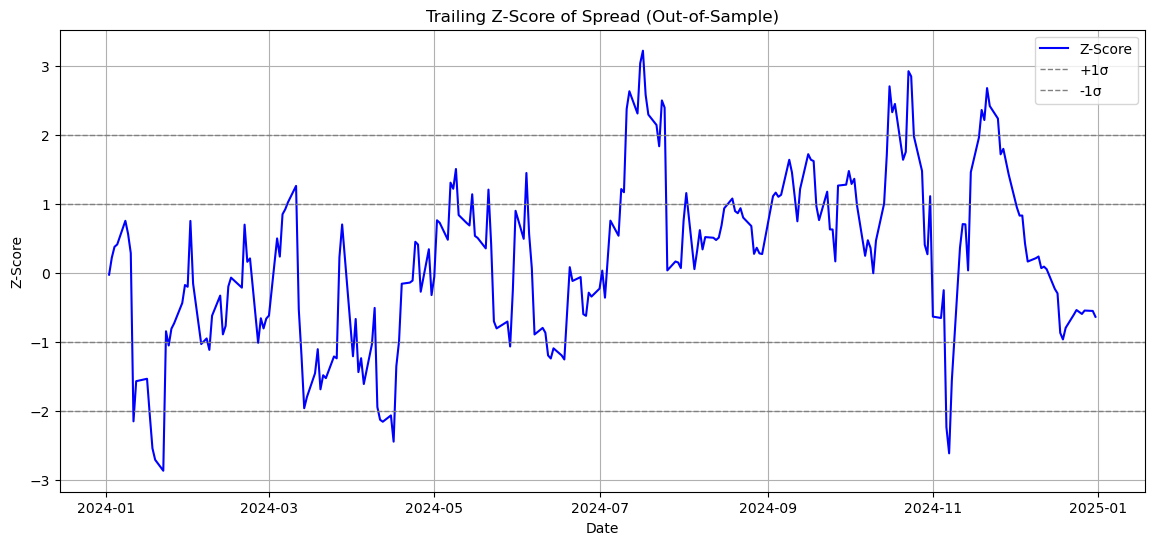

In [141]:
in_sample_start_date = datetime(2022,1,1)
in_sample_end_date = datetime(2023,12,31)

z_score_window_in_days = 50

out_of_sample_start_date = in_sample_end_date + timedelta(days=1)
out_of_sample_end_date = datetime(2025,1,1)

df = pd.read_csv('../data/valid_sp500_pairs.csv', header=None, names=['Pairs'])
df['Pairs'] = df['Pairs'].apply(ast.literal_eval)


for ticker_pair in df['Pairs'].to_list()[:1]:

    # Get prices once for entire evaluation period
    pair_price_history_df = get_adj_close_history_df(ticker_pair, in_sample_start_date, out_of_sample_end_date)
    # calculate gamma over period where cointegration has been validated
    gamma = calculate_historical_gamma(pair_price_history_df, in_sample_start_date, in_sample_end_date)

    # Lagging the out of sample start date is to ensure that there are z scores for the first day of the out of sample period
    #TODO there is a bug here bc pair price history is in trading days but the timedelta calculates in calendar days.
    # doubling the window fixed it for now but it is not precise. 
    spread_series = calculate_spread(
        pair_price_history_df,
        gamma,
        out_of_sample_start_date - timedelta(days=z_score_window_in_days*2),
        out_of_sample_end_date
    )
    out_of_sample_z_score_series = calculate_trailing_zscore(
        spread_series,
        z_score_window_in_days,
        out_of_sample_start_date,
        out_of_sample_end_date
    )
    plot_zscore_zeries(out_of_sample_z_score_series)

In [ ]:
spread_series.rolling(window=z_score_window_in_days).mean().head(20)

Date
2023-09-25          NaN
2023-09-26          NaN
2023-09-27          NaN
2023-09-28          NaN
2023-09-29          NaN
                ...    
2024-07-05    32.777027
2024-07-08    32.774920
2024-07-09    32.783415
2024-07-10    32.805412
2024-07-11    32.835944
Length: 200, dtype: float64

In [130]:
spread_series.head(200)

Date
2023-06-15    36.550660
2023-06-16    36.449027
2023-06-20    36.011454
2023-06-21    36.403068
2023-06-22    36.035488
                ...    
2024-03-26    32.242280
2024-03-27    33.417062
2024-03-28    33.819369
2024-04-01    32.289289
2024-04-02    32.752025
Length: 200, dtype: float64

One initial observation here is that applying the cointegration test over 5 years results in a very low frequency spread meaning there are generally fewer trading opportunities per year. This is potentially a good thing in the sense that it can be exploited to navigate the 10 day calendar hold restriction. Another observation is that the number of relationships to pair trade is combinatorally massive. The number of possible pairs is given by n(n-1)/2 and each of those pairs can be tested for cointegration at different time intervals. Obviously most won't be cointegrated but it provides optimism that perhaps there are pockets of the market where this strategy is not completely arb'd away.

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import coint
from joblib import Parallel, delayed
import itertools
import os

# -----------------------------
# User Inputs
# -----------------------------
# prices_df: pandas DataFrame with dates as index and tickers as columns
# tickers: list of column names (tickers) in prices_df
# You should have these already defined in your environment

correlation_threshold = 0.7  # filter pairs with |corr| below this
output_file = "cointegration_results.csv"  # file to save results
chunk_size = 10000  # how many pairs to process before saving

# -----------------------------
# Generate unique asset pairs
# -----------------------------
pairs = [(a, b) for a, b in itertools.combinations(tickers, 2)]
total_pairs = len(pairs)
print(f"Total unique pairs to test: {total_pairs}")

# -----------------------------
# Define function to process a single pair
# -----------------------------
def process_pair(asset_one, asset_two, prices_df, corr_threshold):
    assets_for_comparison = prices_df[[asset_one, asset_two]].dropna()
    if assets_for_comparison.empty:
        return None

    # Correlation filter
    corr = assets_for_comparison[asset_one].corr(assets_for_comparison[asset_two])
    if abs(corr) < corr_threshold:
        return None

    asset_one_prices = assets_for_comparison[asset_one].to_list()
    asset_two_prices = assets_for_comparison[asset_two].to_list()

    try:
        _, pvalue, _ = coint(asset_one_prices, asset_two_prices)
    except (ZeroDivisionError, ValueError):
        print(f"Asset pair: {asset_one}/{asset_two} were unable to be cointegrated")
        return None

    return (f"{asset_one}_{asset_two}", pvalue)

# -----------------------------
# Process in chunks to save memory
# -----------------------------
results_list = []
for i in range(0, total_pairs, chunk_size):
    chunk_pairs = pairs[i:i+chunk_size]

    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(process_pair)(a, b, prices_df, correlation_threshold) for a, b in chunk_pairs
    )

    # Filter out None results
    results = [r for r in results if r is not None]
    results_list.extend(results)

    # Save chunk to CSV (append mode)
    df_chunk = pd.DataFrame(results, columns=["pair", "pvalue"])
    if not os.path.isfile(output_file):
        df_chunk.to_csv(output_file, index=False)
    else:
        df_chunk.to_csv(output_file, mode='a', header=False, index=False)

    print(f"Processed {min(i+chunk_size, total_pairs)}/{total_pairs} pairs. Saved {len(results)} results.")

# -----------------------------
# Convert final results to dict (optional)
# -----------------------------
cointegration_results = dict(results_list)
print(f"Total cointegrated pairs saved: {len(cointegration_results)}")
